In [1]:
import numpy as np
import gym
import scipy
import cv2
import matplotlib.pyplot as plt
import skimage.transform as st
from PIL import Image
import seaborn as sns

sns.set()

In [2]:
def preproc(X):
    r, g, b = X[:,:,0], X[:,:,1], X[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b

    return st.resize(gray, (28, 28))

In [3]:
def get_theta(obs):
    '''Transforms coordinate basis from the defaults of the gym pendulum env.'''
    theta = np.arctan2(obs[0], -obs[1])
    theta = theta + np.pi/2
    theta = theta + 2*np.pi if theta < -np.pi else theta
    theta = theta - 2*np.pi if theta > np.pi else theta
    return theta

In [4]:
seed=0
timesteps=100
trials=5
side=28
min_angle=0.
max_angle=np.pi/6, 

gym_settings = locals()

env = gym.make('Pendulum-v0')
env.reset() ; env.seed(seed)

canonical_coords, frames = [], []
for step in range(trials * timesteps):

    if step % timesteps == 0:
        angle_ok = False

        while not angle_ok:
            obs = env.reset()
            theta_init = np.abs(get_theta(obs))
            
            if theta_init > min_angle and theta_init < max_angle:
                angle_ok = True
            
    frames.append(preproc(env.render('rgb_array')))
    obs = env.step([0.])[0]
    theta, dtheta = get_theta(obs), obs[-1]

    # The constant factor of 0.25 comes from saying plotting H = PE + KE*c
    # and choosing c such that total energy is as close to constant as
    # possible. It's not perfect, but the best we can do.
    canonical_coords.append(np.array([theta, 0.25 * dtheta]) )

canonical_coords = np.stack(canonical_coords).reshape(trials*timesteps, -1)

(-0.5, 27.5, 27.5, -0.5)

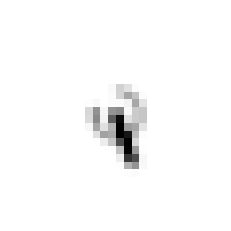

In [5]:
plt.imshow(frames[0], cmap='gray')
plt.axis('off')

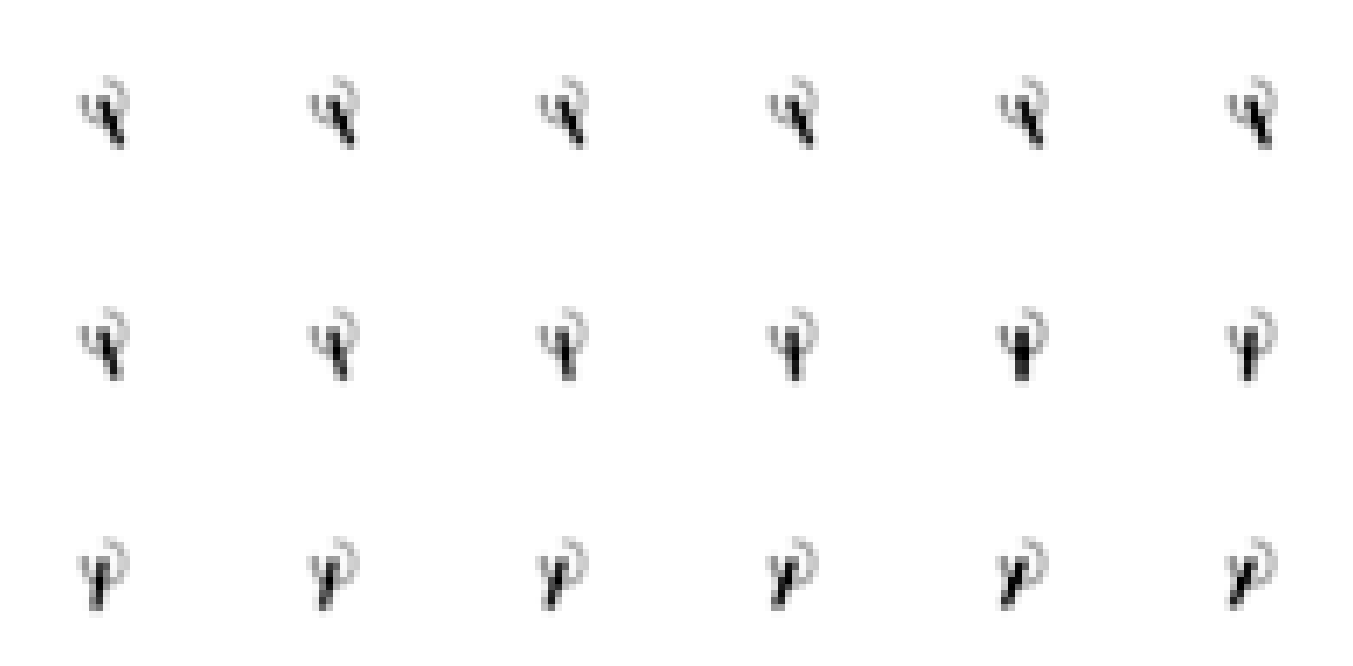

<Figure size 432x288 with 0 Axes>

In [6]:
w=10
h=10
fig=plt.figure(figsize=(24, 12))
columns = 6
rows = 3
for i in range(1, columns*rows +1):
    img = frames[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
plt.show()
plt.tight_layout()


Text(0.5, 1.0, 'Simulated data')

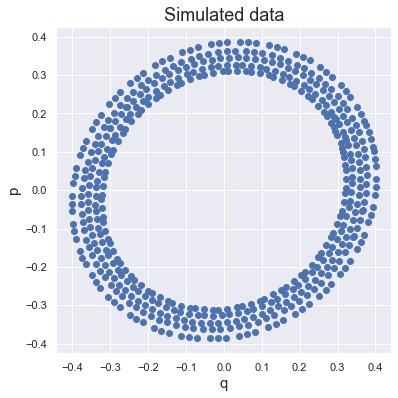

In [7]:
plt.figure(figsize=(6, 6))

plt.plot(canonical_coords[:,0], canonical_coords[:,1], 'o')
plt.xlabel('q', size=15)
plt.ylabel('p', size=15)
plt.title('Simulated data', size=18)